# Import libraries

First we import the libraries to use them later

In [1]:
! pip install visualkeras
! pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=dd7cbdc95f654c42a42b457669e907798c72fbb35274378e10e7bb7311bea36f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import os
import cv2
import time
import math
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import wget
import glob
import shutil
import seaborn
import zipfile
import requests
import visualkeras
import numpy as np
import pandas as pd
import urllib.request
from PIL import Image
import tensorflow as tf
from PIL import ImageFont
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPool2D, Activation, Input, Flatten, Rescaling, concatenate, MaxPooling2D

# Download and create dataset

in this section we download the dataset from:<br> https://figshare.com/articles/dataset/GRAZPEDWRI-DX/14825193

In [3]:
# Download the first file #
url='https://figshare.com/ndownloader/files/35026432'
wget.download(url, out='./')

'.//dataset.csv'

In [4]:
# Download the second file #
url='https://figshare.com/ndownloader/files/34268819'
wget.download(url, out='./')

'.//folder_structure.zip'

In [5]:
# Download the third file #
url='https://figshare.com/ndownloader/files/34268828'
wget.download(url, out='./')

'.//images_part1.zip'

In [6]:
# Download the fourth file #
url='https://figshare.com/ndownloader/files/34268849'
wget.download(url, out='./')

'.//images_part2.zip'

In [7]:
# Download the fifth file #
url='https://figshare.com/ndownloader/files/34268864'
wget.download(url, out='./')

'.//images_part3.zip'

In [8]:
# Download the sixth file #
url='https://figshare.com/ndownloader/files/34268891'
wget.download(url, out='./')

'.//images_part4.zip'

in the next step, we extract all the images

In [9]:
# Your code here #
for file in os.listdir('./'):
  if file.endswith('.zip') and file.startswith('images'):
      with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(f'./dataset/')

Next, due to disk limitations, we delete all zip files

In [10]:
# Your code here #
for file in os.listdir('./'):
  if file.endswith('.zip'):
    os.remove(file)

# Read csv file

In the csv file, we only need the filestem and fracture_visible columns. Here is a description of them:

*   <b>filestem:<br> </b> the name of images (note that we should add 'png' to them)
*   <b>fracture_visible: </b> <br> image labels (note that the labels are binary and we replace 'Nan' values with '0') <br>
---
As it is clear from the csv file, we have 20327 photos







In [11]:
# Your code here #
df = pd.read_csv('dataset.csv', usecols=['filestem', 'fracture_visible'])
print(df)

                             filestem  fracture_visible
0      0001_1297860395_01_WRI-L1_M014               NaN
1      0001_1297860435_01_WRI-L2_M014               1.0
2      0002_0354485735_01_WRI-R1_F012               NaN
3      0002_0354485759_01_WRI-R2_F012               NaN
4      0003_0662359226_01_WRI-R1_M011               1.0
...                               ...               ...
20322  6091_0590289015_02_WRI-L2_F008               NaN
20323  6092_0295935784_01_WRI-L1_M003               NaN
20324  6092_0295935837_01_WRI-L2_M003               NaN
20325  6093_0885712402_01_WRI-L1_M008               1.0
20326  6093_0885712456_01_WRI-L2_M008               1.0

[20327 rows x 2 columns]


# Create dataloader

In [12]:
df['filestem'][0]

'0001_1297860395_01_WRI-L1_M014'

Our images are grayscale so we convert them to RGB becase the models input must have three channels.<br> Then we resize the images to (224,224,3) becuase all input images must be the same size.

In [13]:
size = 224
image_dir = './dataset/'
!mkdir data
idx = 0
for index, f in enumerate(df['filestem']):
  img = cv2.imread(os.path.join(image_dir, f"{f}.png"), cv2.IMREAD_GRAYSCALE)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img_resized = cv2.resize(img_rgb, (size, size))
  if df['fracture_visible'][idx] == 1:
    if not os.path.exists('./data/class1'):
      os.makedirs('./data/class1')
    output_file = os.path.join('./data/class1', f"{f}.png")
    cv2.imwrite(output_file, img_resized)
  else:
    if not os.path.exists('./data/class0'):
      os.makedirs('./data/class0')
    output_file = os.path.join('./data/class0', f"{f}.png")
    cv2.imwrite(output_file, img_resized)
  idx+=1

Due to RAM limitations, we should use dataloader and batch size.<br> Here is some information about data after the dataloader is created:

*   <b> Image shape: </b> (224, 224, 3)
*   <b> Number of channels: </b> 3
*   <b> Channel format: </b> RGB
*   <b> Data scale: </b> 0 to 1
*   <b> Batch size: </b> 64
*   <b> Validation size: </b> 20%
*   <b> Data type: </b> float32








In [153]:
  # Your code here #
data_dir='./data/'

image_shape = (224, 224, 3)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=True)

Found 16262 images belonging to 2 classes.
Found 4065 images belonging to 2 classes.


In [154]:
train_size = train_generator.samples
validation_size = val_generator.samples

# plot some images

In this section we show some images and their labels with matplotlib library

In [155]:
def visualize(data,figsize,shape):
    '''
      visualize some samples
      input(s):
        data (int): The dataset we want to show some examples of
        figsize (tuple): size of images for display
        shape (tuple): number of images for display
      output(s):
        visualize some samples
    '''

    # obtain one batch of training images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=figsize)
    x,y = shape
    for idx in np.arange(x*y):
        ax = fig.add_subplot(x, y, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        ax.set_title(str(labels[idx].argmax()))

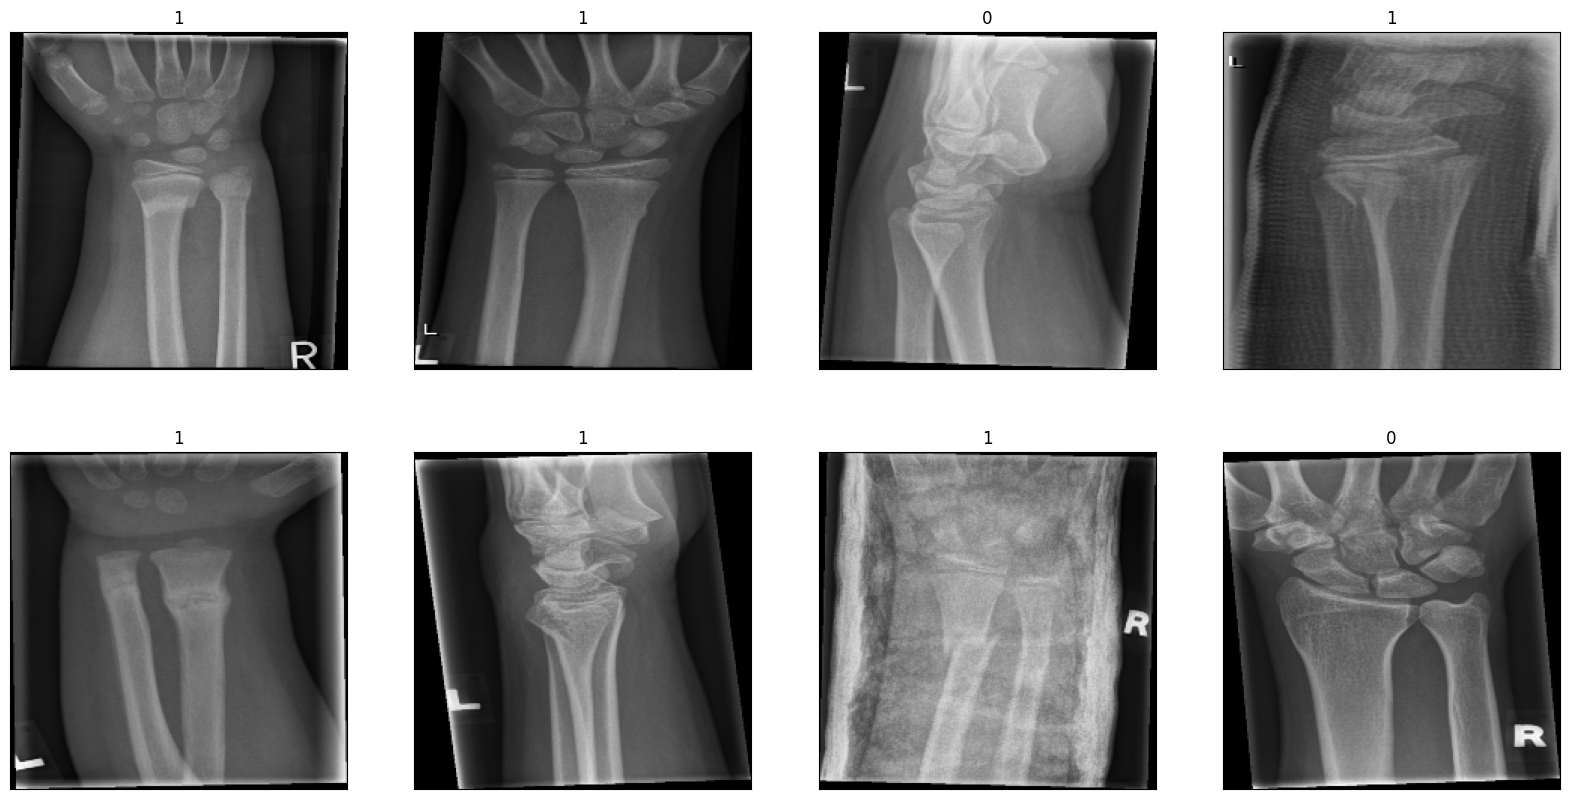

In [156]:
visualize(train_generator,(20,10),(2,4))

# Define models

We use transfer learning with imagenet weights for training our models.<br> We fine tune the last two layers and use a multi layer perceptron(MLP) with a hidden layer of size 128 and two neurons in the last layer for prediction. <br> Also we use Categorical CrossEntropy as the loss function and Adam as the optimizer. <br> 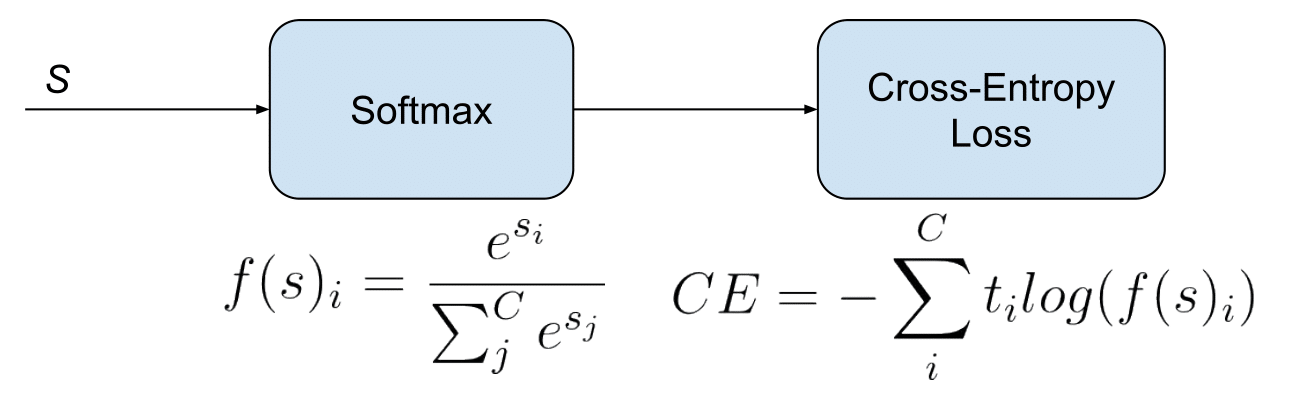

in this section we define a function that takes `conv_model` as input and we want to fine-tune our model.

Note: please tune the last two layers of the conv model and then create a mlp with 128 hidden layer and `relu` function for activation.

In [177]:
def define_model(conv_model):
    for layer in conv_model.layers:
        layer.trainable = False

    # Your code here #
    x = Flatten()(conv_model.output)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    full_model.summary()
    full_model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'],)
    return full_model

# Training

# Define fnctions for plots

In [117]:
def loss_plot(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model_history.history['loss']);
    plt.title('Training Loss');
    plt.subplot(1,2,2)
    plt.plot(model_history.history['val_loss']);
    plt.title('validation Loss');
    plt.show()

def acc_plot(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(VGG_history.history['accuracy']);
    plt.title('Training accuracy');
    plt.subplot(1,2,2)
    plt.plot(VGG_history.history['val_accuracy']);
    plt.title('validation accuracy');
    plt.show()

def cm_plot(model):
    test_labels = []
    predict_labels =[]
    for i in range(0,int(64)):
        test_labels.extend(np.array(val_generator[i][1]))
        predict_labels.extend(np.array(model.predict(val_generator[i][0], verbose = 0)))
    test_labels = np.array(test_labels)
    test_labels = test_labels.argmax(axis=1)
    predict_labels = np.array(predict_labels)
    predict_labels = predict_labels.argmax(axis=1)

    cm = confusion_matrix(test_labels, predict_labels)
    info=['0','1']
    plt.figure(figsize = (12,12))
    ax = seaborn.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels = info, yticklabels = info)
    ax.set_ylabel('Actual', fontsize=40)
    ax.set_xlabel('Predicted', fontsize=40)
    print(cm)
    plt.show()

def visualizer(data, model, figsize, shape):
    # obtain one batch of test images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # get sample predictions
    preds = model.predict(images).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=figsize)
    x,y = shape
    for idx in np.arange(x*y):
      ax = fig.add_subplot(x, y, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                  color=("green" if preds[idx]==labels[idx] else "red"))

## VGG

VGG, which stands for Visual Geometry Group, is a convolutional neural network (CNN) architecture designed for image classification and recognition tasks. It was proposed by researchers from the University of Oxford in the paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition."

The VGG architecture is known for its depth, featuring 16 to 19 layers of convolutional and fully connected layers. The key characteristics of VGG networks are the use of small 3x3 convolutional filters with a stride of 1, which helps preserve spatial resolution while increasing the depth, and max-pooling layers for down-sampling.

The VGG architecture has multiple versions, including VGG16 and VGG19, with varying numbers of layers. These models have been widely used and are benchmarks in the field of computer vision for various image-related tasks such as image classification, object detection, and segmentation. We use VGG16 in this project.

In [118]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(size,size,3))
VGG_model = define_model(conv_model)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

show model structure

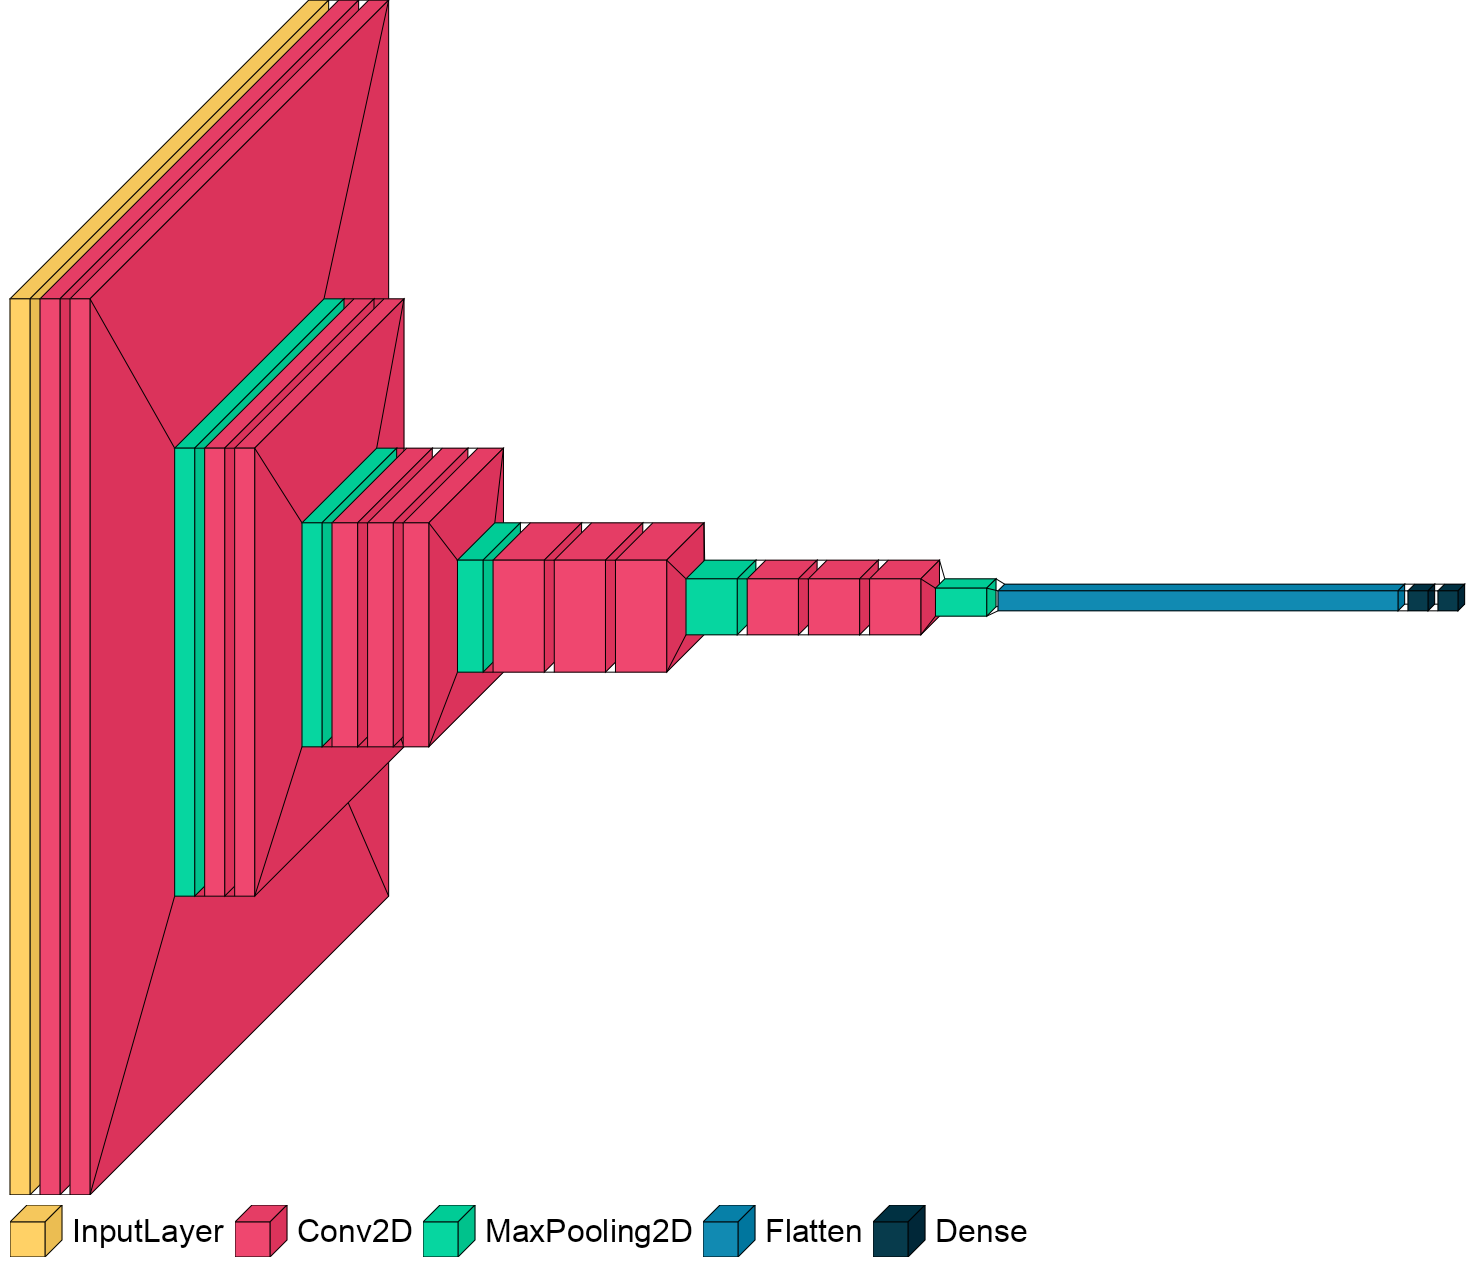

In [119]:
font = ImageFont.truetype("Arial.ttf", 32)
visualkeras.layered_view(VGG_model, legend=True, font=font, max_z=400)

In [120]:
name = './unet_model.h5'
checkp = [EarlyStopping(patience=2),
              ModelCheckpoint(name, monitor = 'accuracy', save_best_only = True, verbose = 1)]
start_time = time.time()
VGG_history = VGG_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [checkp]
)

VGG_time = time.time() - start_time
VGG_model_parameters = VGG_model.count_params()

<ipython-input-120-bc2e8f1b5aa1>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  VGG_history = VGG_model.fit_generator(


Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.5878 - accuracy: 0.7289
Epoch 1: accuracy improved from -inf to 0.72888, saving model to ./unet_model.h5
255/255 [==============================] - 90s 347ms/step - loss: 0.5878 - accuracy: 0.7289 - val_loss: 0.4779 - val_accuracy: 0.7483
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.7946
Epoch 2: accuracy improved from 0.72888 to 0.79461, saving model to ./unet_model.h5
255/255 [==============================] - 107s 421ms/step - loss: 0.4377 - accuracy: 0.7946 - val_loss: 0.4329 - val_accuracy: 0.7875
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8215
Epoch 3: accuracy improved from 0.79461 to 0.82155, saving model to ./unet_model.h5
255/255 [==============================] - 88s 345ms/step - loss: 0.3845 - accuracy: 0.8215 - val_loss: 0.4354 - val_accuracy: 0.7931
Epoch 4/10
255/255 [==============================] - ETA: 0

In [121]:
VGG_train_acc = VGG_history.history['accuracy']
VGG_val_acc = VGG_history.history['val_accuracy']
VGG_train_loss = VGG_history.history['loss']
VGG_val_loss = VGG_history.history['val_loss']

now we want to plot:

*   Training Loss
*   Validation Loss
*   Training Accuracy
*   Validation Accuracy
*   Confusion Matrix





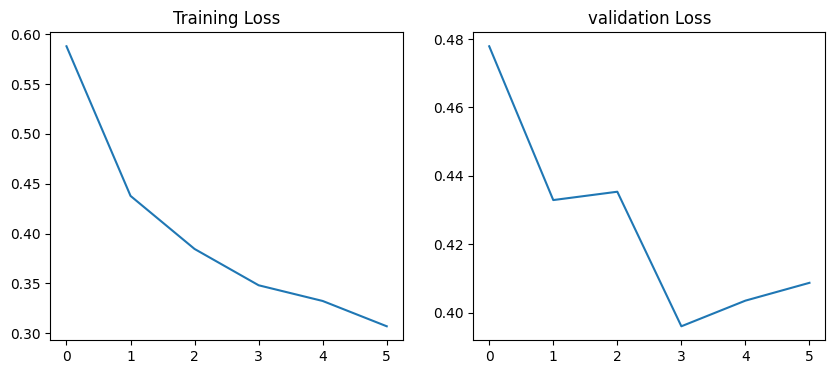

In [122]:
loss_plot(VGG_history)

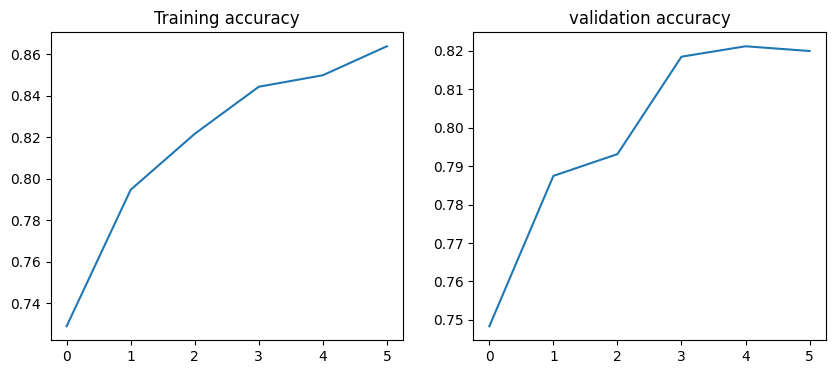

In [123]:
acc_plot(VGG_history)

[[ 814  541]
 [ 191 2519]]


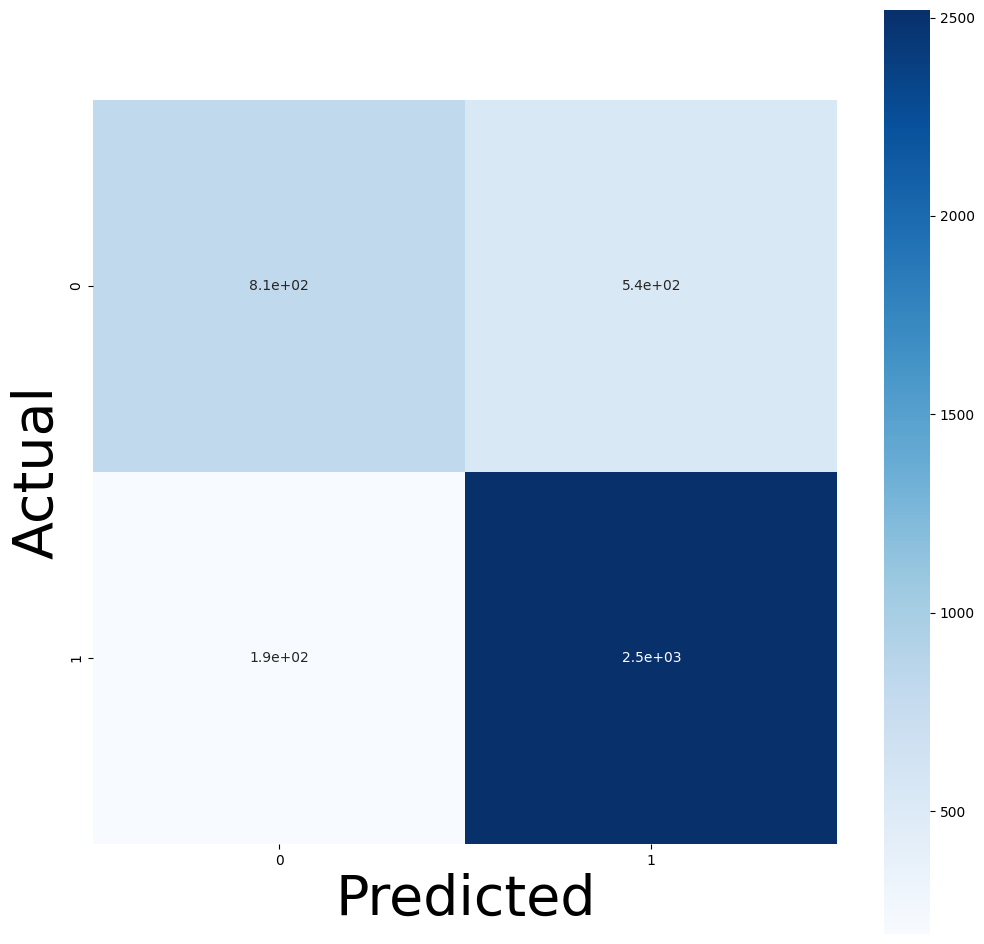

In [124]:
cm_plot(VGG_model)

2/2 [==============================] - 0s 120ms/step


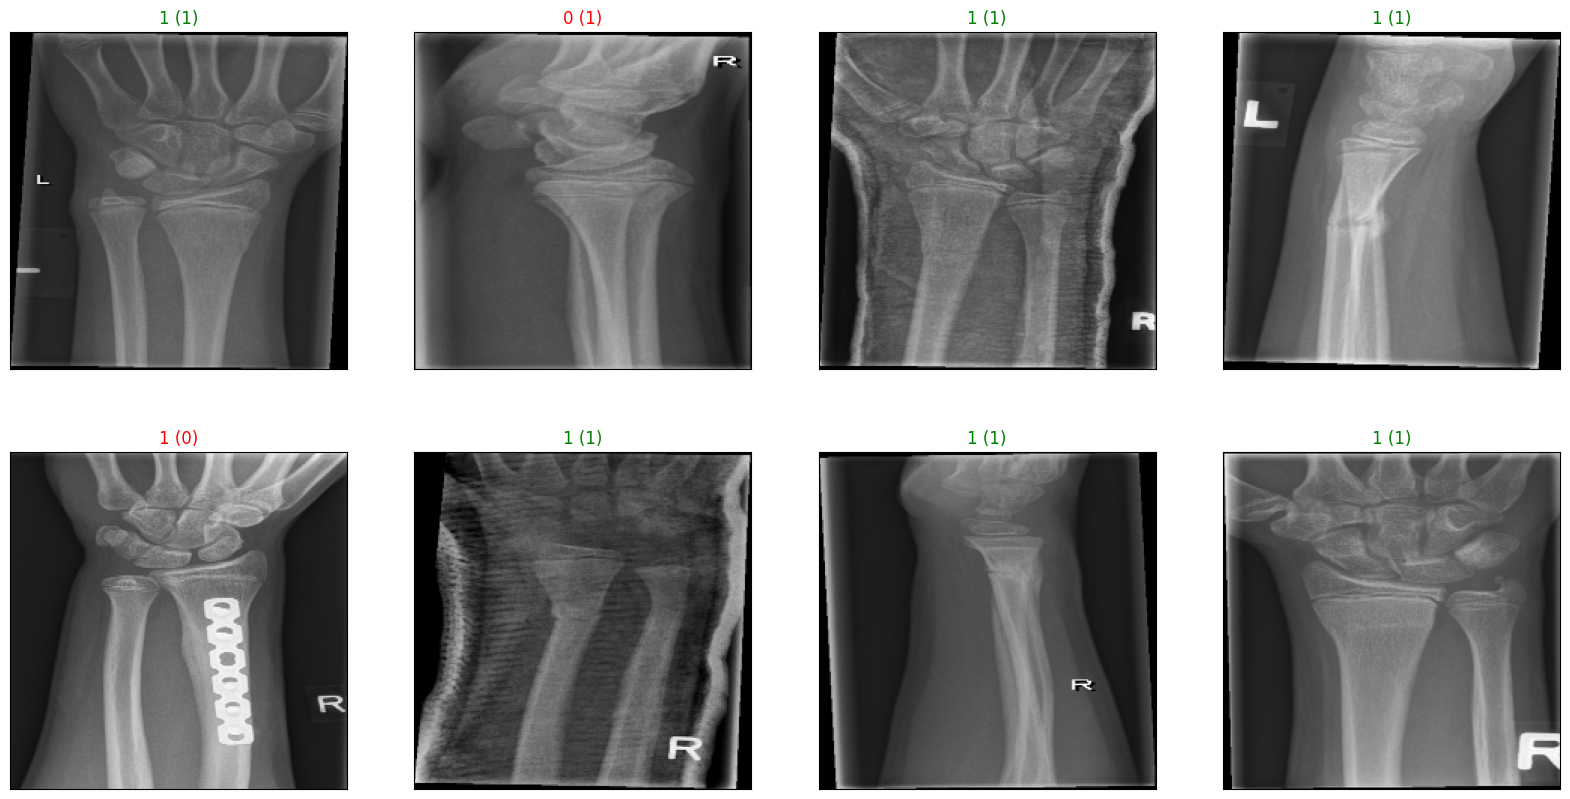

In [125]:
visualizer(val_generator, VGG_model, (20,10), (2,4))

## Resnet

ResNet, short for Residual Network, is a deep convolutional neural network architecture that was introduced by researchers Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their 2015 paper titled "Deep Residual Learning for Image Recognition." It won the 2016 ImageNet competition, demonstrating its effectiveness in image classification tasks.

The key innovation in ResNet is the use of residual blocks, which address the vanishing gradient problem that often occurs in very deep neural networks. The vanishing gradient problem can make it challenging for traditional deep networks to learn effectively as the gradients become extremely small, hindering the training process.

In a residual block, instead of trying to learn the mapping directly, the network learns residual functions. The output of a layer is added to the input, creating a shortcut connection (or "skip connection"). This enables the network to learn the difference or residual between the input and the desired output, making it easier for the network to learn identity mappings. The residual blocks allow the model to efficiently train very deep networks by mitigating the vanishing gradient issue.

The architecture of ResNet consists of multiple residual blocks stacked on top of each other, forming a deep neural network. Different versions of ResNet, such as ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, are based on the number and structure of these residual blocks. We use ResNet-50 in this project.

ResNet has had a significant impact on the field of computer vision and deep learning, especially in image recognition tasks. Its concepts of residual learning and skip connections have been incorporated and adapted in various architectures to improve training and performance in deep neural networks.

In [178]:
resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(size,size,3))
resnet_model = define_model(conv_model)

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_30[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

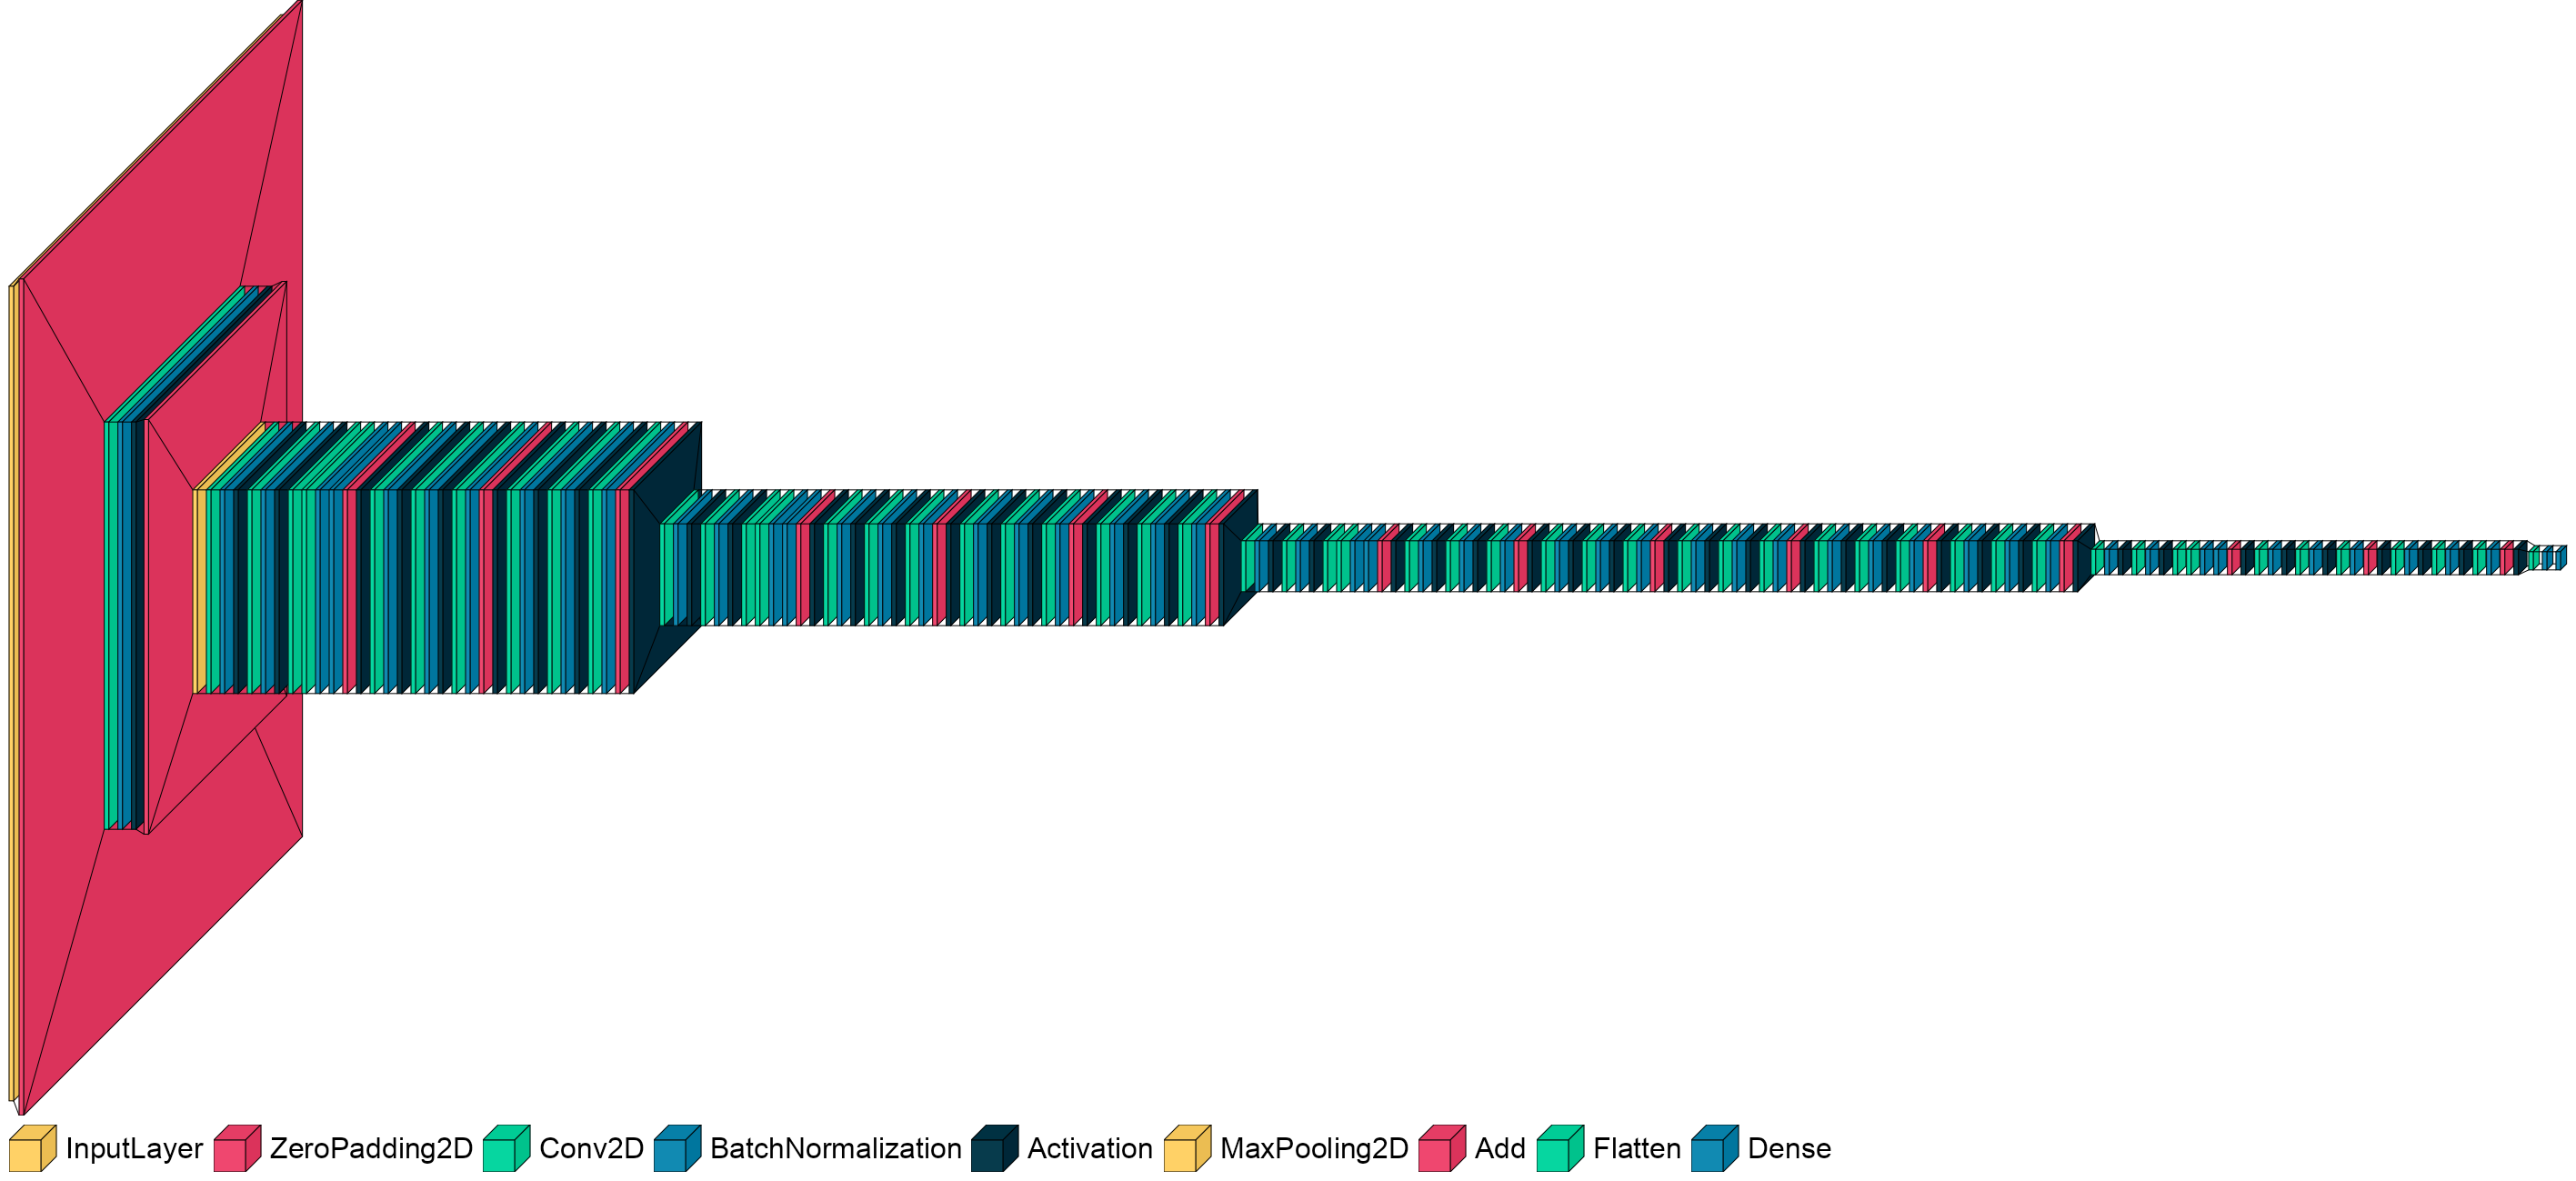

In [179]:
font = ImageFont.truetype("Arial.ttf", 32)
visualkeras.layered_view(resnet_model, legend=True, font=font, max_z=5)

In [180]:
name = './unet_model.h6'
checkp = [EarlyStopping(patience=2),
              ModelCheckpoint(name, monitor = 'accuracy', save_best_only = True, verbose = 1)]
start_time = time.time()
resnet_history = resnet_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [checkp]
)
resnet_time = time.time() - start_time
resnet_model_parameters = resnet_model.count_params()

<ipython-input-180-12961c9edb21>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_history = resnet_model.fit_generator(


Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.6437
Epoch 1: accuracy improved from -inf to 0.64371, saving model to ./unet_model.h6
255/255 [==============================] - 207s 798ms/step - loss: 0.8806 - accuracy: 0.6437 - val_loss: 0.5862 - val_accuracy: 0.6667
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.6663
Epoch 2: accuracy improved from 0.64371 to 0.66628, saving model to ./unet_model.h6
255/255 [==============================] - 103s 405ms/step - loss: 0.5625 - accuracy: 0.6663 - val_loss: 0.5650 - val_accuracy: 0.6723
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.6921
Epoch 3: accuracy improved from 0.66628 to 0.69210, saving model to ./unet_model.h6
255/255 [==============================] - 127s 497ms/step - loss: 0.5524 - accuracy: 0.6921 - val_loss: 0.5474 - val_accuracy: 0.7046
Epoch 4/10
255/255 [==============================] - ETA:

In [187]:
resnet_train_acc = resnet_history.history['accuracy']
resnet_val_acc = resnet_history.history['val_accuracy']
resnet_train_loss = resnet_history.history['loss']
resnet_val_loss = resnet_history.history['val_loss']

now we want to plot:

*   Training Loss
*   Validation Loss
*   Training Accuracy
*   Validation Accuracy
*   Confusion Matrix


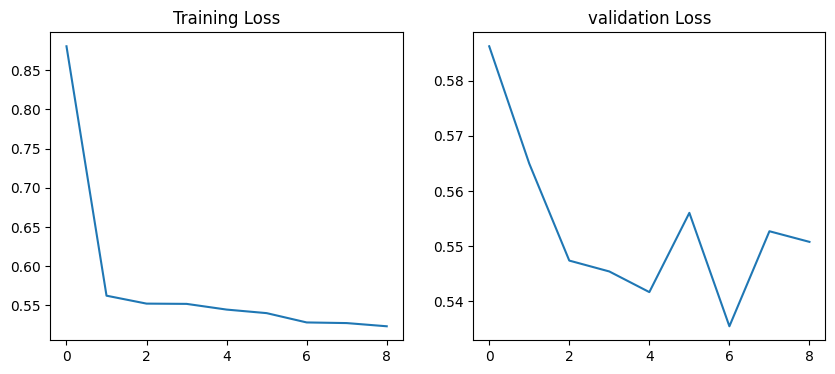

In [188]:
loss_plot(resnet_history)

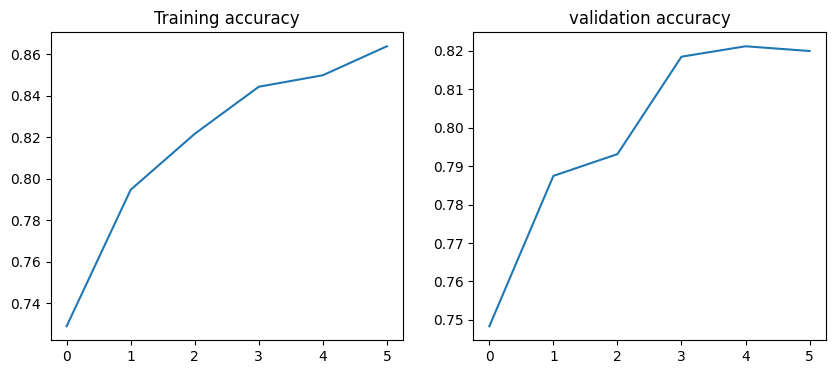

In [189]:
acc_plot(resnet_history)

[[ 962  393]
 [ 872 1838]]


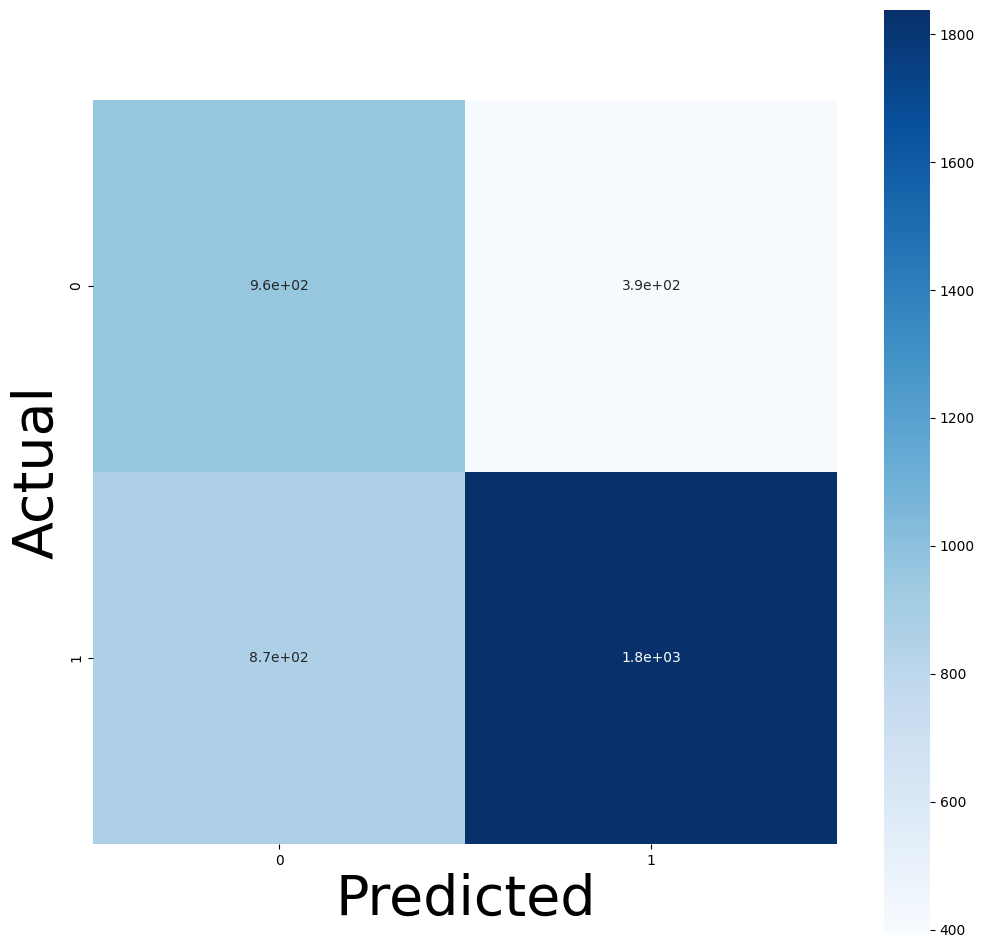

In [190]:
cm_plot(resnet_model)

2/2 [==============================] - 0s 85ms/step


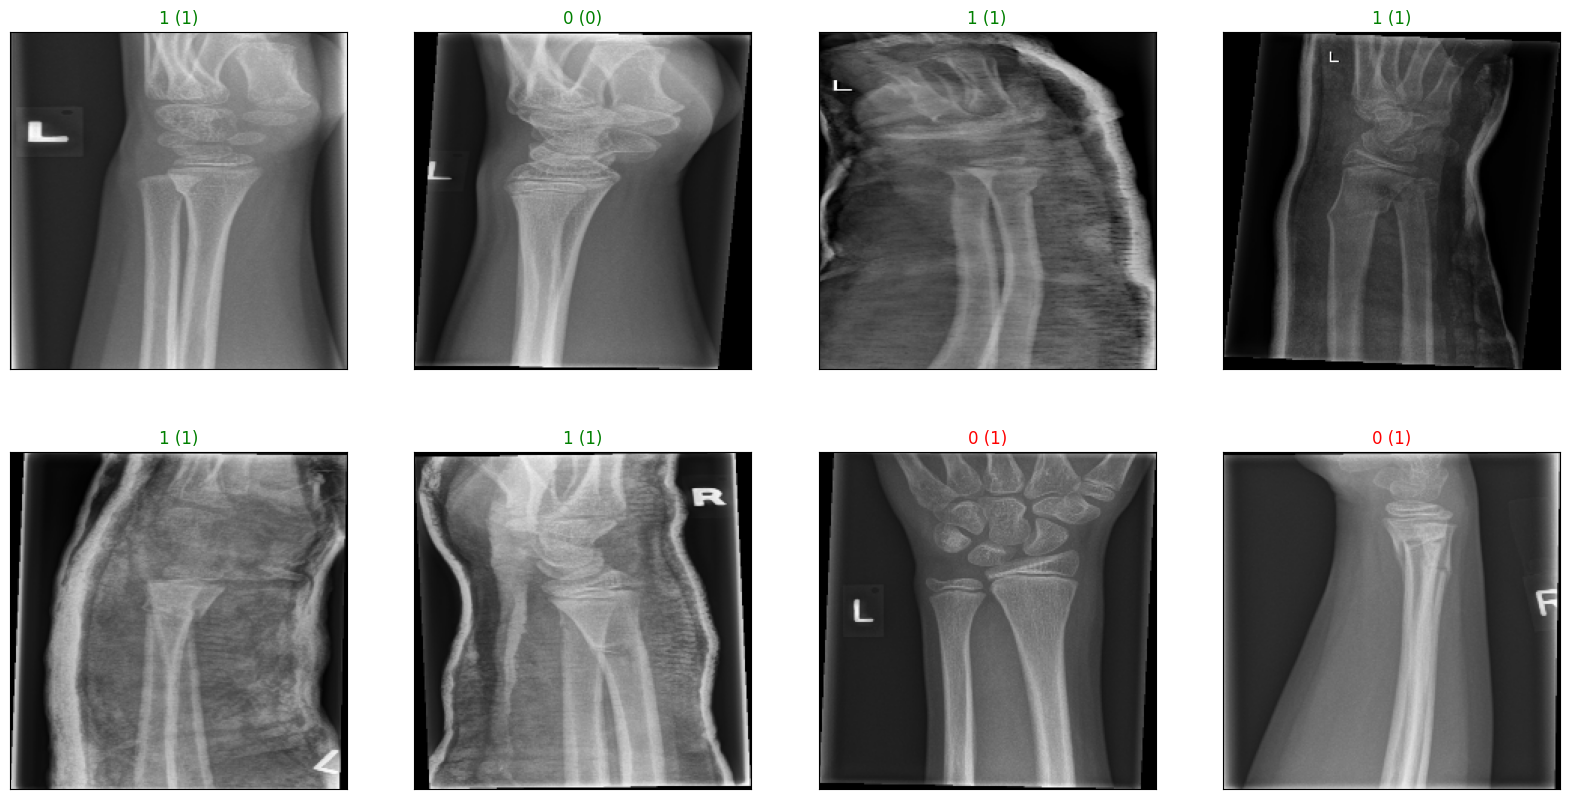

In [191]:
visualizer(val_generator, resnet_model, (20,10), (2,4))

# Conclusion

At the end, we compare the results in the form of a table

In [192]:
myTable = PrettyTable(["model", "number of train data", "number of test data", "train accuracy", "test accuracy", "time", "parametes"])

# Add rows
# Your code here #
myTable.add_row(["VGG", len(train_generator), len(val_generator), VGG_train_acc[-1], VGG_val_acc[-1], VGG_time, VGG_model_parameters])
myTable.add_row(["ResNet", len(train_generator), len(val_generator), resnet_train_acc[-1], resnet_val_acc[-1], resnet_time, resnet_model_parameters])
print(myTable)

+--------+----------------------+---------------------+--------------------+--------------------+-------------------+-----------+
| model  | number of train data | number of test data |   train accuracy   |   test accuracy    |        time       | parametes |
+--------+----------------------+---------------------+--------------------+--------------------+-------------------+-----------+
|  VGG   |         255          |          64         | 0.8637313842773438 | 0.8199262022972107 | 607.0054521560669 |  17926338 |
| ResNet |         255          |          64         | 0.7208215594291687 | 0.6888068914413452 | 1043.476484298706 |  36433154 |
+--------+----------------------+---------------------+--------------------+--------------------+-------------------+-----------+
